In [18]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import cv2 as cv
from tqdm import tqdm
import string
from sklearn.model_selection import train_test_split
from tensorflow.keras.backend import ctc_decode, get_value
from utils import preprocess_image


In [19]:
PATH = '../dataset/Date-Synth/images/'

In [20]:
ANNOTATIONS_PATH = '../dataset/Date-Synth/annotations.json'

with open(ANNOTATIONS_PATH, 'r') as file:
    data = json.load(file)

def get_y_from_json(file: str) -> str:
    return " ".join(annotation['transcription'] for annotation in data[file]['ann'])

In [21]:
get_y_from_json('00001.jpg')

'10 10 2016'

Loading images:   0%|          | 0/1 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


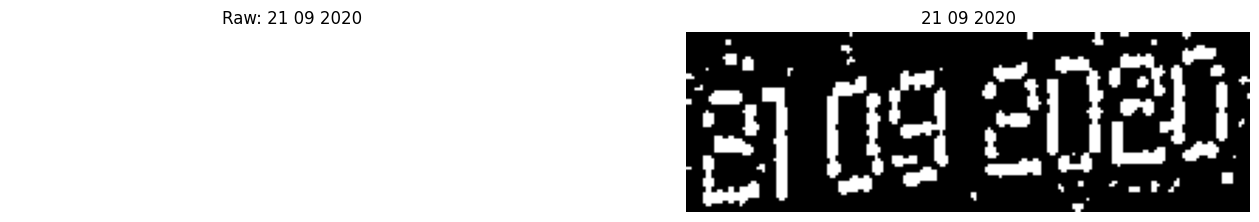

Loading images: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


In [22]:
target_size = (32, 100)

for idx, file in enumerate(tqdm(os.listdir(PATH)[:1], total=1, desc="Loading images")):
    file_path = os.path.join(PATH, file)

    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='rgb', target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)

    preprocessed = preprocess_image(image, resize= True)
    preprocessed = np.expand_dims(preprocessed, axis= -1)
    
    label = get_y_from_json(file)

    plt.figure(figsize=(16, 9))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Raw: {label}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(preprocessed, cmap='gray')
    plt.title(label)
    plt.axis('off')
    
    plt.show()

Loading images: 100%|██████████| 11840/11840 [00:07<00:00, 1600.00it/s]


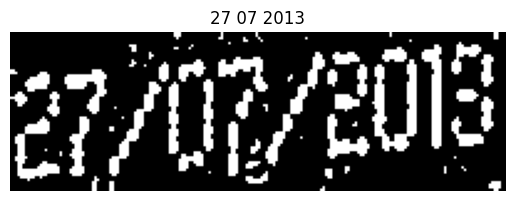

In [23]:
# Load dataset

X = []
Y = []

target_size = (32, 100)

n = 11840

for idx, file in enumerate(tqdm(os.listdir(PATH)[:n], total=n, desc="Loading images")):

    file_path = os.path.join(PATH, file)

    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='rgb', target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    
    image = preprocess_image(image, resize= True)
    image = np.expand_dims(image, axis= -1)

    label = get_y_from_json(file)

    if label != " ":
        X.append(image)
        Y.append(label)

X = np.array(X)
Y = np.array(Y)
    
plt.imshow(X[100], cmap='gray')
plt.title(Y[100])
plt.axis('off')
plt.show()

In [24]:
# Normalized

X_normalized = X / 255.0

print(f'X shape: {X_normalized.shape} | Y shape: {Y.shape}')
print(f'X_normalized[0]: {X_normalized[0]} | Y[0]: {Y[0]}')

X shape: (11840, 64, 200, 1) | Y shape: (11840,)
X_normalized[0]: [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]] | Y[0]: 21 09 2020


In [56]:
# Encode

char_list = string.ascii_letters + string.digits + ' ' # Digits because only for expiration date

index_to_char = {idx: character for idx, character in enumerate(char_list)}

def encode_label(label: str) -> list:
    
    encoded = []

    for char in label:
        try:
            encoded.append(char_list.index(char))
        except:
            print(f'Not found in char_list: {char}')

    return encoded

def decode_label(encoded) -> list:
        
    decoded = []

    for char_idx in encoded:
        
        if int(char_idx) != -1 and int(char_idx) != len(char_list): # -1 -> _ in CTC and len(char_list) -> pad
            
            decoded.append(index_to_char[char_idx])
                
    return decoded

def preprocess_label(Y):
    
    Y_encoded = [encode_label(label) for label in Y]
    max_len = max(len(seq) for seq in Y_encoded)
    Y_padded = tf.keras.preprocessing.sequence.pad_sequences(Y_encoded, maxlen= max_len, padding='post', value=len(char_list))
    
    return Y_padded


In [57]:
# Pad sequence

Y_padded = preprocess_label(Y)

In [28]:
# Split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y_padded, test_size= 0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size= 0.5, random_state=42)

In [29]:
# Define input shape


input_shape = X[0].shape

input_shape

(64, 200, 1)

In [30]:
class MapToSequenceLayer(tf.keras.layers.Layer):

    def __call__(self, inputs):

        # Input = (batch_size, height, width, channels) => Feature Map

        batch_size = tf.shape(inputs)[0]
        height = tf.shape(inputs)[1]
        width = tf.shape(inputs)[2]
        channels = tf.shape(inputs)[3]


        # Output = (batch_size, width, height * channels) => sequence per columns

        outputs = tf.reshape(inputs, (batch_size, width, height * channels))

        return outputs
    
    def get_config(self):
        config = super(MapToSequenceLayer, self).get_config()
        return config

In [31]:
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, name: str = 'CTCLoss') -> None:

        super(CTCLoss, self).__init__()
        self.name = name
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def __call__(self, y_true: tf.Tensor, y_pred: tf.Tensor, sample_weight= None) -> tf.Tensor:

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)

        return loss
    
    def get_config(self):
        config = super(CTCLoss, self).get_config()
        return config


In [32]:
# Model

def create_model(LR = 0.001):

    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Conv2D(512, kernel_size=(2, 2), padding='valid', activation='relu'),
        MapToSequenceLayer(),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Dense(len(char_list) + 1, activation='softmax')
    ])

    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= LR), loss= CTCLoss())

    return model

LR = 0.0005

model = create_model(LR)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 200, 64)       640       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 100, 64)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 100, 128)      73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 50, 128)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 50, 256)       295168    
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 50, 256)      

In [33]:
print(Y_train[0])
print(len(char_list) + 1)
print(model.output_shape)


[52 54 62 29 30 28 62 54 59 63 63]
64
(None, 49, 64)


In [42]:
BATCH_SIZE = 16
EPOCHS = 20

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5,           
    mode='min',           
    verbose=1,            
)

history = model.fit(X_train, Y_train, 
          validation_data= (X_val, Y_val), 
          batch_size= BATCH_SIZE, 
          epochs= EPOCHS,
          callbacks=[early_stopping_cb])


Epoch 1/20
592/592 [==============================] - 56s 94ms/step - loss: 0.9797 - val_loss: 2.1099
Epoch 2/20
592/592 [==============================] - 56s 94ms/step - loss: 0.6809 - val_loss: 2.2358
Epoch 3/20
592/592 [==============================] - 60s 101ms/step - loss: 0.5628 - val_loss: 2.2200
Epoch 4/20
592/592 [==============================] - 58s 98ms/step - loss: 0.4693 - val_loss: 2.5453
Epoch 5/20
592/592 [==============================] - 57s 97ms/step - loss: 0.3623 - val_loss: 2.2120
Epoch 6/20
592/592 [==============================] - 57s 96ms/step - loss: 0.3844 - val_loss: 2.2112
Epoch 6: early stopping


In [45]:
model.save_weights('acc_76_model.weights')

In [70]:
def character_accuracy(pred_text, truth_text):
    correct_chars = sum([1 for p, t in zip(pred_text, truth_text) if p == t])
    return correct_chars / len(truth_text) if len(truth_text) > 0 else 0.0

def exact_match_accuracy(pred_text, truth_text):
    return 1 if pred_text == truth_text else 0

def manual_evaluate(Y_pred, Y_test):

    ctc_input_length = np.ones(Y_pred.shape[0]) * Y_pred.shape[1]
    output = get_value(ctc_decode(Y_pred, input_length= ctc_input_length, greedy= True)[0][0])
    
    correct_char_count = 0
    exact_match_count = 0
    total_samples = Y_pred.shape[0] 

    for idx in range(total_samples):
        pred_text = ''.join([char for char in decode_label(output[idx])])
        truth_text = ''.join([char for char in decode_label(Y_test[idx])])

        char_acc = character_accuracy(pred_text, truth_text)
        exact_acc = exact_match_accuracy(pred_text, truth_text)
        
        correct_char_count += char_acc
        exact_match_count += exact_acc

    avg_char_accuracy = correct_char_count / total_samples
    avg_exact_accuracy = exact_match_count / total_samples

    print(f"Average character-level accuracy: {avg_char_accuracy:.4f}")
    print(f"Average exact match accuracy: {avg_exact_accuracy}")
    
    return output, avg_char_accuracy, avg_exact_accuracy
    

In [65]:
Y_pred = model.predict(X_test)

manual_evaluate(Y_pred, Y_test)


37/37 [==============================] - 1s 38ms/step
Average character-level accuracy: 0.9171
Average exact match accuracy: 0.7668918918918919


Test with Real Data

In [46]:
REAL_PATH = '../dataset/Date-Real/images/'
REAL_ANNOTATIONS_PATH = '../dataset/Date-Real/annotations.json'

with open(REAL_ANNOTATIONS_PATH, 'r') as file:
    data = json.load(file)

def get_y_from_json(file: str) -> str:
    return " ".join(annotation['transcription'] for annotation in data[file]['ann'])

Loading images: 100%|██████████| 510/510 [00:00<00:00, 1421.46it/s]


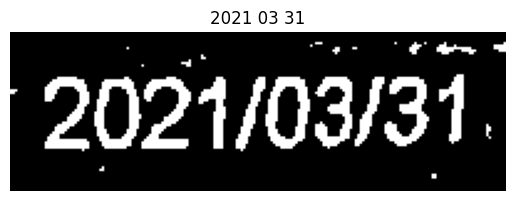

In [62]:
# Load dataset

X_real = []
Y_real = []

target_size = (32, 100)

n = 510

for idx, file in enumerate(tqdm(os.listdir(REAL_PATH)[:n], total=n, desc="Loading images")):

    file_path = os.path.join(REAL_PATH, file)

    image = tf.keras.preprocessing.image.load_img(file_path, color_mode='rgb', target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    
    image = preprocess_image(image, resize= True)
    image = np.expand_dims(image, axis= -1)

    label = get_y_from_json(file)

    if label != " ":
        X_real.append(image)
        Y_real.append(label)

X_real = np.array(X_real)
Y_real = np.array(Y_real)
    
plt.imshow(X_real[100], cmap='gray')
plt.title(Y_real[100])
plt.axis('off')
plt.show()

Y_padded_real = preprocess_label(Y_real)

In [71]:
# Use saved model

saved_model = create_model()
saved_model.load_weights('acc_76_model.weights')
        
Y_pred = saved_model.predict(X_real)

output, _, _ = manual_evaluate(Y_pred, Y_padded_real)

16/16 [==============================] - 2s 39ms/step
Average character-level accuracy: 0.9340
Average exact match accuracy: 0.8156862745098039


In [74]:
from datetime import datetime

def format_to_datestring(str):
    
    date_obj = datetime.strptime(str, "%Y %m %d")
    formatted_date = date_obj.strftime("%d %B %Y")
    
    return formatted_date

for idx in range(5):
    pred_text = ''.join([char for char in decode_label(output[idx])])
    truth_text = ''.join([char for char in decode_label(Y_padded_real[idx])])

    print(f'Truth: {format_to_datestring(truth_text)} | Pred: {format_to_datestring(pred_text)}')


Truth: 23 May 2021 | Pred: 23 May 2021
Truth: 16 May 2021 | Pred: 16 May 2021
Truth: 10 September 2022 | Pred: 10 September 2022
Truth: 12 May 2021 | Pred: 12 May 2021
Truth: 01 June 2023 | Pred: 01 June 2023
